In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from tqdm import tqdm
from torch_geometric.utils import from_networkx
import sys
sys.path.append('../../..')
from aiagents4pharma.talk2knowledgegraphs.datasets.primekg import PrimeKG
from aiagents4pharma.talk2knowledgegraphs.datasets.starkqa_primekg import StarkQAPrimeKG
from aiagents4pharma.talk2knowledgegraphs.utils.embeddings.ollama import EmbeddingWithOllama
from aiagents4pharma.talk2knowledgegraphs.utils import kg_utils

import matplotlib.pyplot as plt

# # Set the logging level for httpx to WARNING to suppress INFO messages
import logging
logging.getLogger("httpx").setLevel(logging.WARNING)

/home/oneai/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_dir = '../../../aiagents4pharma/talk2knowledgegraphs/tests/files/primekg_ibd_pyg_graph.pkl'

In [3]:
with open(local_dir, 'rb') as file:
    data = pickle.load(file)

data

Data(x=[3426, 768], edge_index=[2, 12752], edge_attr=[12752, 768], node_id=[3426], node_name=[3426], node_type=[3426], enriched_node=[3426], key=[12752], head_id=[12752], head_name=[12752], tail_id=[12752], tail_name=[12752], edge_type=[12752], enriched_edge=[12752])

In [4]:
G = nx.Graph()

# Add nodes to the graph
for i in range(len(data['node_id'])):
    G.add_node(
        data['node_id'][i],
        name=data['node_name'][i],
        type=data['node_type'][i],
        enriched_node=data['enriched_node'][i],
        features=data['x'][i].numpy(),  # You can add the node features as well
    )

# Add edges to the graph
for i in range(data['edge_index'].shape[1]):  # 12752 edges
    head = data['head_id'][i]
    tail = data['tail_id'][i]
    G.add_edge(
        head,
        tail,
        edge_attr=data['edge_attr'][i].numpy(),
        edge_type=data['edge_type'][i],
        enriched_edge=data['enriched_edge'][i]
    )

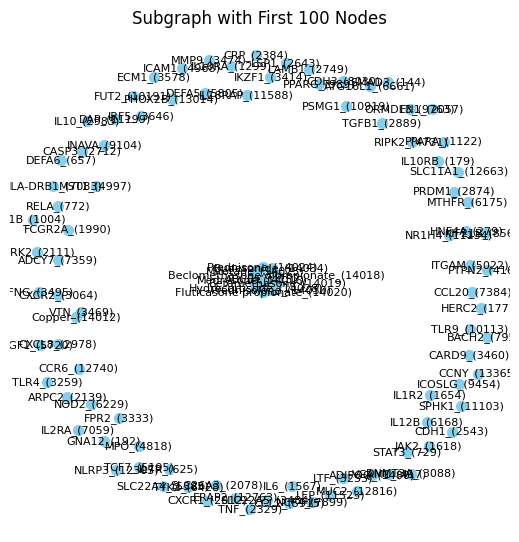

In [5]:
first_100_nodes = list(G.nodes)[:100]

subgraph = G.subgraph(first_100_nodes)

plt.figure(figsize=(5, 5))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8, node_color='skyblue')
plt.title("Subgraph with First 100 Nodes")
plt.show()


----------

### Bert model - transforming from text to tensor

In [6]:
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import torch

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=256)
    outputs = model(**inputs)
    # Get the mean of the hidden states (contextual embeddings)
    
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()  # Shape: (1, hidden_size)

# Example: Get embedding for a species description
text_description = "STAT3 belongs to gene/protein category. The protein encoded by this gene is a member of the STAT protein family. In response to cytokines and growth factors, STAT family members are phosphorylated by the receptor associated kinases, and then form homo- or heterodimers that translocate to the cell nucleus where they act as transcription activators. This protein is activated through phosphorylation in response to various cytokines and growth factors including IFNs, EGF, IL5, IL6, HGF, LIF and BMP2."
text_embedding = get_text_embedding(text_description)


### Graph behaviour

We pass each enriched node text through the BERT model to obtain an embedding

In [8]:
import gc

nodes_list = list(G.nodes)
total_len = len(nodes_list)
batch_size = 100  # You can adjust this batch size for when to invoke garbage collection

for node_idx in range(total_len):
    node = nodes_list[node_idx]
    print(f"{node_idx} / {total_len}")
    
    try:
        if 'enriched_node' in G.nodes[node]:
            text = G.nodes[node]['enriched_node']
            G.nodes[node]['BERT_embedding'] = get_text_embedding(text)
        else:
            print(f"Warning: 'enriched_node' not found for node {node}")
    except Exception as e:
        print(f"Error processing node {node}: {e}")
    
    # Optionally, invoke garbage collection after every `batch_size` nodes processed
    if node_idx % batch_size == 0 and node_idx != 0:
        gc.collect()  # Force garbage collection to free memory


0 / 3426
1 / 3426
2 / 3426
3 / 3426
4 / 3426
5 / 3426
6 / 3426
7 / 3426
8 / 3426
9 / 3426
10 / 3426
11 / 3426
12 / 3426
13 / 3426
14 / 3426
15 / 3426
16 / 3426
17 / 3426
18 / 3426
19 / 3426
20 / 3426
21 / 3426
22 / 3426
23 / 3426
24 / 3426
25 / 3426
26 / 3426
27 / 3426
28 / 3426
29 / 3426
30 / 3426
31 / 3426
32 / 3426
33 / 3426
34 / 3426
35 / 3426
36 / 3426
37 / 3426
38 / 3426
39 / 3426
40 / 3426
41 / 3426
42 / 3426
43 / 3426
44 / 3426
45 / 3426
46 / 3426
47 / 3426
48 / 3426
49 / 3426
50 / 3426
51 / 3426
52 / 3426
53 / 3426
54 / 3426
55 / 3426
56 / 3426
57 / 3426
58 / 3426
59 / 3426
60 / 3426
61 / 3426
62 / 3426
63 / 3426
64 / 3426
65 / 3426
66 / 3426
67 / 3426
68 / 3426
69 / 3426
70 / 3426
71 / 3426
72 / 3426
73 / 3426
74 / 3426
75 / 3426
76 / 3426
77 / 3426
78 / 3426
79 / 3426
80 / 3426
81 / 3426
82 / 3426
83 / 3426
84 / 3426
85 / 3426
86 / 3426
87 / 3426
88 / 3426
89 / 3426
90 / 3426
91 / 3426
92 / 3426
93 / 3426
94 / 3426
95 / 3426
96 / 3426
97 / 3426
98 / 3426
99 / 3426
100 / 3426

### We add neighbor embeddings

In [9]:
proportions = [.2, .05]  # example proportions for hops 1 and 2
total_len = len(nodes_list)

# Loop through all nodes
for node_idx in range(total_len):
    print(node_idx)
    
    node_name = nodes_list[node_idx]
    node = G.nodes[node_name]
    embedding = node['BERT_embedding']
    weight = 1  # Start with weight 1 for the node itself
    
    # To keep track of nodes we've already considered (avoiding duplicate neighbors)
    seen_nodes = set([node_name])  # Add the node itself to avoid reprocessing it
    
    for prop_idx in range(len(proportions)):
        # Find neighbors N hops away (for hops 1, 2, etc.)
        nodes_n_hops_away = [
            neighbor for neighbor, dist in nx.single_source_shortest_path_length(G, node_name).items() 
            if dist == prop_idx + 1 and neighbor not in seen_nodes
        ]
        
        # Update the seen nodes with the current level's neighbors
        seen_nodes.update(nodes_n_hops_away)
        
        # Add the embeddings for these neighbors, weighted by proportion
        for neighbor_idx in nodes_n_hops_away:
            neighbor_node = G.nodes[neighbor_idx]
            embedding += neighbor_node['BERT_embedding'] * proportions[prop_idx]
            weight += proportions[prop_idx]  # Add the weight of the current hop level

    # Normalize the final embedding by the total weight
    node['FINAL_embedding'] = embedding / weight
    #print(f"Final embedding for node {node_name}: {node['FINAL_embedding']}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
na = nodes_list[1]
G.nodes[na]['BERT_embedding']

array([[-1.22916520e+00,  7.57784009e-01,  2.71029258e+00,
        -2.25457048e+00,  4.14110804e+00, -2.87758446e+00,
         3.77812004e+00,  2.44133019e+00, -7.52721250e-01,
        -1.18511960e-01, -2.54704762e+00, -6.03854895e+00,
        -2.25275326e+00,  5.18417263e+00,  2.99816668e-01,
         6.43604660e+00,  1.70552170e+00,  2.83542228e+00,
        -4.40001428e-01,  3.65091324e+00,  3.86671257e+00,
        -2.27832723e+00, -2.64009356e-01,  5.83076334e+00,
         3.36806393e+00, -5.18283725e-01, -1.60897911e+00,
         2.54178667e+00,  2.22784328e+00, -2.19471574e+00,
         2.77472782e+00,  3.26249719e+00, -1.64441824e+00,
         1.61222315e+00, -3.36888337e+00,  8.98069292e-02,
        -2.74233747e+00, -2.38199782e+00,  1.73858249e+00,
         4.07512903e+00, -7.10620642e+00, -5.92878389e+00,
        -5.45392036e+00,  1.83437836e+00, -1.33326304e+00,
        -3.39008164e+00,  3.91771960e+00,  5.14734173e+00,
         1.90660524e+00, -1.36705351e+00, -4.68373728e+0

### Obtain most similar embedding

In [11]:
best_node = None
best_sim = -1

for node_name in nodes_list:
    curr_emb = G.nodes[node_name]['FINAL_embedding']

    curr_emb = curr_emb.flatten()
    text_embedding = text_embedding.flatten()
    
    #cosine_sim = np.dot(curr_emb, text_embedding) / (np.linalg.norm(curr_emb) * np.linalg.norm(text_embedding))
    linear_sim = np.linalg.norm(curr_emb - text_embedding)
    print(linear_sim)
    if ((best_node is None) | (linear_sim < best_sim)):
        best_node = node_name
        best_sim = linear_sim

5.3094707
3.7479894
4.25238
4.854794
5.018378
5.0496874
5.6753287
4.9480615
5.195637
5.074986
5.8564906
5.570511
15.469068
7.935748
7.115003
6.4524913
22.56122
20.650793
21.559465
22.882952
11.887986
26.266844
9.679993
28.906958
9.017548
35.53873
25.933327
58.799248
18.855234
37.3941
39.88105
16.133383
40.09184
28.896896
47.59633
47.693672
39.934837
27.861528
60.947464
98.07189
73.49915
72.30503
55.813175
51.99156
53.255375
108.60236
118.22601
12.551326
99.35158
75.3244
96.9784
85.71741
209.59702
135.92644
186.82121
129.94577
101.368385
237.36769
140.35071
121.23792
225.71393
117.983955
229.63371
347.55658
292.79425
185.72679
325.1911
351.3663
375.0525
530.291
422.79227
590.13995
565.8334
582.8261
589.39795
291.7676
651.0442
804.5638
375.02396
386.3813
1030.0886
310.58173
987.78845
644.03503
553.369
771.5694
1088.4943
1319.2728
872.4906
1394.349
70.56705
16.216078
17.398453
18.651115
19.957493
21.342264
22.805904
24.338966
25.951136
27.6484
29.442156
31.32348
33.319088
35.396343
37.583

In [12]:
best_node

'IL10RB_(179)'

In [13]:
best_sim

3.7479894

In [14]:
G.nodes[best_node]

{'name': 'IL10RB',
 'type': 'gene/protein',
 'enriched_node': 'IL10RB belongs to gene/protein category. The protein encoded by this gene belongs to the cytokine receptor family. It is an accessory chain essential for the active interleukin 10 receptor complex. Coexpression of this and IL10RA proteins has been shown to be required for IL10-induced signal transduction. This gene and three other interferon receptor genes, IFAR2, IFNAR1, and IFNGR2, form a class II cytokine receptor gene cluster located in a small region on chromosome 21. [provided by RefSeq, Jul 2008].',
 'features': array([ 2.47649457e-02,  2.27820016e-02, -1.69560522e-01, -3.35070789e-02,
         8.52039382e-02, -4.47765887e-02,  4.06866398e-04,  3.38708200e-02,
         8.85483692e-04, -5.48509024e-02, -2.48616599e-02,  4.08173949e-02,
         5.26165143e-02, -9.47317749e-04,  6.65599257e-02, -2.95930486e-02,
        -2.54397616e-02,  1.05780065e-02,  2.82950737e-02,  3.88805866e-02,
        -3.57877351e-02, -2.41180

In [15]:
G.nodes['STAT3_(729)']

{'name': 'STAT3',
 'type': 'gene/protein',
 'enriched_node': 'STAT3 belongs to gene/protein category. The protein encoded by this gene is a member of the STAT protein family. In response to cytokines and growth factors, STAT family members are phosphorylated by the receptor associated kinases, and then form homo- or heterodimers that translocate to the cell nucleus where they act as transcription activators. This protein is activated through phosphorylation in response to various cytokines and growth factors including IFNs, EGF, IL5, IL6, HGF, LIF and BMP2. This protein mediates the expression of a variety of genes in response to cell stimuli, and thus plays a key role in many cellular processes such as cell growth and apoptosis. The small GTPase Rac1 has been shown to bind and regulate the activity of this protein. PIAS3 protein is a specific inhibitor of this protein. This gene also plays a role in regulating host response to viral and bacterial infections. Mutations in this gene are